# 使用說明

Data cleaning/Clean
底下Set BU選擇BU

Train with whole year/Set time
img_path: 結果儲存位置
do_group: 要不要group


This notebook focuses on country, frequency and prod group trend.

In [78]:
from datetime import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sys
import json
import warnings
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn
# warnings.filterwarnings( "ignore", module = "matplotlib/..*" )
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(''))


Auto mode patch

In [79]:
try:
    get_ipython
    isnb = True
except:
    isnb = False

auto_mode = not isnb
config_path = 'C:/Users/eric/Desktop/ML_test/keras/predict_transaction/country/country_split2_config.json'
if auto_mode:
    with open(config_path) as f:
        config = json.load(f)
img_path = 'C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/country_split'

if auto_mode:
    config['result'] = {}
    with open(config_path, 'w+') as f:
        json.dump(config, f, indent=4)


def write_config(key, value):
    config['result'][key] = value
    with open(config_path, 'w+') as f:
        json.dump(config, f, indent=4)

if not isnb:
    def display(*args, **kwargs):
        pass

    def plt_show_func(*args, **kwargs):
        pass
    plt.show = plt_show_func


## Data parsing

In [80]:
# filename = 'all.csv'
# filename = 'SC_ABC_RSBU.csv'
filename = 'SC_201807_202207.csv'
filepath = f'{filename}'
display(filepath)


'SC_201807_202207.csv'

In [81]:
df_ori = pd.read_csv(filepath)
df_ori.rename(columns={'RepCust': 'CustomerID', 'ScNo': 'InvoiceNo', 'Qty': 'Quantity',
              'ScDate': 'InvoiceDate', 'NetUPrice': 'UnitPrice', 'MarketRegion': 'Country'}, inplace=True)
df_ori['InvoiceDate'] = pd.to_datetime(df_ori['InvoiceDate'])


In [82]:
display(df_ori)


,Unnamed: 0,BU,OrgCOmpany,ScId,ScDetailId,InvoiceNo,CustomerID,ScCust,ScCustProf,PlanReCust,...,Beta,SaDeduct,AdjustPrice,UnitPrice,RptYear,RptMonth,TranCd,InvoiceDate,KeyInDate,Salesman
0,1,REBU,JU,290064,459596,JOT187D0017,阿姆斯壯,阿姆斯壯,卷材地板,阿姆斯壯,...,NaN,NaN,NaN,8960.59,2018,7,U,2018-07-02,07-02-18,夏濟潤
1,2,REBU,JU,290066,459604,JTM187D0009,揚州亞明,揚州亞明,電線電纜膠粒,揚州亞明,...,NaN,NaN,NaN,12000.00,2018,7,C,2018-07-02,07-02-18,冷家陽
2,7,REBU,JU,290084,459630,JOT187D0019,天長格瑞,天長格瑞,電線電纜膠粒,天長格瑞,...,NaN,NaN,NaN,9150.00,2018,7,U,2018-07-02,07-02-18,張坤
3,9,REBU,JU,290094,459644,JOP187D0040,溧陽恆業,溧陽恆業,建材﹑裝飾材料,溧陽恆業,...,NaN,NaN,NaN,8700.00,2018,7,U,2018-07-02,07-02-18,杜克增
4,10,REBU,JU,290096,459648,JOA187D0013,江蘇天邦,江蘇天邦,輸送帶,江蘇天邦,...,NaN,NaN,NaN,11675.20,2018,7,U,2018-07-02,07-02-18,殷海濤
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90097,99,MABU,VN,3384,4100,VOP227T0010,HOAPHU,HOAPHU,鞋材、鞋粒,HOAPHU,...,0.0,0.0,2000000.0,38000000.00,2022,7,C,2022-07-13,07-13-22,Roger Nguyen
90098,102,MABU,VN,3378,4094,VOT227T0003,Vitahco,Vitahco,直接出口,Vitahco,...,0.0,0.0,883333.0,36883333.00,2022,7,U,2022-07-12,07-12-22,Roger Nguyen
90099,103,MABU,VN,3366,4082,VOP227T0008,HUE LINH.,HUE LINH.,建材﹑裝飾材料,HUE LINH.,...,0.0,0.0,3050000.0,39050000.00,2022,7,U,2022-07-11,07-11-22,Roger Nguyen
90100,107,MABU,VN,3364,4080,VOP227T0006,THPHAT,THPHAT,食品包裝,THPHAT,...,0.0,0.0,1635000.0,38635000.00,2022,7,U,2022-07-07,07-07-22,Roger Nguyen


In [83]:
df = df_ori.copy()
display(df.columns)
df = df.drop([
    'Unnamed: 0', 'ScId', 'ScDetailId', 'InvoiceNo',
    'ScCust', 'PlanReCust',
    'PackMatCd',
    'ScGrade', 'IssuePlace', 'BasePrice', 'Added',
    'Beta', 'SaDeduct', 'AdjustPrice', 'RptYear', 'RptMonth',
    'TranCd', 'KeyInDate', 'Salesman',
], 1)


Index(['Unnamed: 0', 'BU', 'OrgCOmpany', 'ScId', 'ScDetailId', 'InvoiceNo',
       'CustomerID', 'ScCust', 'ScCustProf', 'PlanReCust', 'PlanReCustIncity',
       'Country', 'Prod', 'Grade', 'PackDesp', 'PackMatCd', 'Quantity',
       'ScGrade', 'IssuePlace', 'Cur', 'BasePrice', 'Added', 'Beta',
       'SaDeduct', 'AdjustPrice', 'UnitPrice', 'RptYear', 'RptMonth', 'TranCd',
       'InvoiceDate', 'KeyInDate', 'Salesman'],
      dtype='object')

In [84]:
display('init df')
display(df)
display(df.describe())
display(df.nunique())


'init df'

,BU,OrgCOmpany,CustomerID,ScCustProf,PlanReCustIncity,Country,Prod,Grade,PackDesp,Quantity,Cur,UnitPrice,InvoiceDate
0,REBU,JU,阿姆斯壯,卷材地板,江蘇吳江,蘇州地區,UN488,一般級N,散裝,89.85,RMB,8960.59,2018-07-02
1,REBU,JU,揚州亞明,電線電纜膠粒,江蘇揚州,揚州地區,TOTM,一般級N,散裝,2.00,RMB,12000.00,2018-07-02
2,REBU,JU,天長格瑞,電線電纜膠粒,安徽天長,安徽地區0,UN488,一般級N,散裝,10.00,RMB,9150.00,2018-07-02
3,REBU,JU,溧陽恆業,建材﹑裝飾材料,江蘇溧陽,常州地區,DOP,一般級N,散裝,20.00,RMB,8700.00,2018-07-02
4,REBU,JU,江蘇天邦,輸送帶,江蘇泰州,泰州地區,DOA,一般級N,190KG新桶裝,0.38,RMB,11675.20,2018-07-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90097,MABU,VN,HOAPHU,鞋材、鞋粒,"H. Binh Chanh,HCM",VIETNAM,DOP-T,General N,Bulk,21.00,VND,38000000.00,2022-07-13
90098,MABU,VN,Vitahco,直接出口,******,VIETNAM,UN488-T,General N,Bulk,21.00,VND,36883333.00,2022-07-12
90099,MABU,VN,HUE LINH.,建材﹑裝飾材料,******,VIETNAM,DOP-T,General N,Bulk,22.00,VND,39050000.00,2022-07-11
90100,MABU,VN,THPHAT,食品包裝,TRAN DAI NGHIA,VIETNAM,DOP-T,General N,Bulk,15.00,VND,38635000.00,2022-07-07


,Quantity,UnitPrice
count,90102.000000,9.010200e+04
mean,50.500311,2.738594e+05
std,85.199741,3.135741e+06
min,0.005000,3.300000e+01
25%,20.000000,7.354000e+03
50%,30.000000,8.950000e+03
75%,60.000000,1.177400e+04
max,4704.000000,5.737630e+07


BU                      6
OrgCOmpany             12
CustomerID           1789
ScCustProf             70
PlanReCustIncity      604
Country                89
Prod                  105
Grade                  23
PackDesp               46
Quantity             4551
Cur                     5
UnitPrice           16430
InvoiceDate          1213
dtype: int64

Add Invoice Month

In [85]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceMonthStr'] = df['InvoiceMonth'].astype(str)


Convert price to USD

In [86]:
display('Currency')
display(df['Cur'].unique())


'Currency'

array(['RMB', 'MYR', 'THB', 'VND', 'NTD'], dtype=object)

In [87]:
currency_table = {
    'RMB': 0.14,
    'NTD': 0.33,
    'USD': 1,
    'MYR': 0.22,
    'THB': 0.27,
    'VND': 0.000043,
}
df['USPrice'] = df['Cur'].map(currency_table) * df['UnitPrice']


Create monetary

In [88]:
# df['Monetary'] = df['USPrice'] * df['Quantity']
df['Monetary'] = df['UnitPrice'] * df['Quantity']


In [89]:
display('changed df')
display(df)
display(df.describe())
display(df.nunique())


'changed df'

,BU,OrgCOmpany,CustomerID,ScCustProf,PlanReCustIncity,Country,Prod,Grade,PackDesp,Quantity,Cur,UnitPrice,InvoiceDate,InvoiceMonth,InvoiceMonthStr,USPrice,Monetary
0,REBU,JU,阿姆斯壯,卷材地板,江蘇吳江,蘇州地區,UN488,一般級N,散裝,89.85,RMB,8960.59,2018-07-02,2018-07,2018-07,1254.482600,8.051090e+05
1,REBU,JU,揚州亞明,電線電纜膠粒,江蘇揚州,揚州地區,TOTM,一般級N,散裝,2.00,RMB,12000.00,2018-07-02,2018-07,2018-07,1680.000000,2.400000e+04
2,REBU,JU,天長格瑞,電線電纜膠粒,安徽天長,安徽地區0,UN488,一般級N,散裝,10.00,RMB,9150.00,2018-07-02,2018-07,2018-07,1281.000000,9.150000e+04
3,REBU,JU,溧陽恆業,建材﹑裝飾材料,江蘇溧陽,常州地區,DOP,一般級N,散裝,20.00,RMB,8700.00,2018-07-02,2018-07,2018-07,1218.000000,1.740000e+05
4,REBU,JU,江蘇天邦,輸送帶,江蘇泰州,泰州地區,DOA,一般級N,190KG新桶裝,0.38,RMB,11675.20,2018-07-02,2018-07,2018-07,1634.528000,4.436576e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90097,MABU,VN,HOAPHU,鞋材、鞋粒,"H. Binh Chanh,HCM",VIETNAM,DOP-T,General N,Bulk,21.00,VND,38000000.00,2022-07-13,2022-07,2022-07,1634.000000,7.980000e+08
90098,MABU,VN,Vitahco,直接出口,******,VIETNAM,UN488-T,General N,Bulk,21.00,VND,36883333.00,2022-07-12,2022-07,2022-07,1585.983319,7.745500e+08
90099,MABU,VN,HUE LINH.,建材﹑裝飾材料,******,VIETNAM,DOP-T,General N,Bulk,22.00,VND,39050000.00,2022-07-11,2022-07,2022-07,1679.150000,8.591000e+08
90100,MABU,VN,THPHAT,食品包裝,TRAN DAI NGHIA,VIETNAM,DOP-T,General N,Bulk,15.00,VND,38635000.00,2022-07-07,2022-07,2022-07,1661.305000,5.795250e+08


,Quantity,UnitPrice,USPrice,Monetary
count,90102.000000,9.010200e+04,90102.000000,9.010200e+04
mean,50.500311,2.738594e+05,1680.779453,1.015691e+07
std,85.199741,3.135741e+06,2369.999379,1.463321e+08
min,0.005000,3.300000e+01,4.620000,5.000000e+01
25%,20.000000,7.354000e+03,1031.800000,1.807785e+05
50%,30.000000,8.950000e+03,1253.980000,2.888765e+05
75%,60.000000,1.177400e+04,1647.800000,5.042400e+05
max,4704.000000,5.737630e+07,45858.780000,8.775765e+09


BU                      6
OrgCOmpany             12
CustomerID           1789
ScCustProf             70
PlanReCustIncity      604
Country                89
Prod                  105
Grade                  23
PackDesp               46
Quantity             4551
Cur                     5
UnitPrice           16430
InvoiceDate          1213
InvoiceMonth           49
InvoiceMonthStr        49
USPrice             16696
Monetary            44390
dtype: int64

In [90]:
display(df.loc[df['Quantity'] < 1])


,BU,OrgCOmpany,CustomerID,ScCustProf,PlanReCustIncity,Country,Prod,Grade,PackDesp,Quantity,Cur,UnitPrice,InvoiceDate,InvoiceMonth,InvoiceMonthStr,USPrice,Monetary
4,REBU,JU,江蘇天邦,輸送帶,江蘇泰州,泰州地區,DOA,一般級N,190KG新桶裝,0.38,RMB,11675.2,2018-07-02,2018-07,2018-07,1634.528,4436.576
27,REBU,JU,江蘇名陽,膠布（薄膜）,江蘇江陰,無錫地區,UN399,一般級N,200KG新桶裝,0.40,RMB,13000.0,2018-07-02,2018-07,2018-07,1820.000,5200.000
101,REBU,JU,嘉興海源,密封壓條,浙江桐鄉,浙北,DINP,一般級N,200KG新桶裝,0.40,RMB,9006.4,2018-07-06,2018-07,2018-07,1260.896,3602.560
112,REBU,JU,嘉興海源,密封壓條,浙江桐鄉,浙北,DOP,一般級N,200KG新桶裝,0.40,RMB,9006.4,2018-07-06,2018-07,2018-07,1260.896,3602.560
127,REBU,JU,3M,貼膠,上海松江,上海浦西,UN615-T,一般級N,200KG新桶裝,0.20,RMB,22758.8,2018-07-09,2018-07,2018-07,3186.232,4551.760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89704,RSBU,ZU,華創隆佛山,電線電纜膠粒,佛山市順德區勒流鎮,廣東珠三角,UN640,一般級N,散裝,0.06,RMB,16900.0,2022-07-07,2022-07,2022-07,2366.000,1014.000
89942,RWBU,NP,舒氏集團,粘膠,孝感市孝南區,武漢,TOTM-T,一般級N,200KG新桶裝,0.40,RMB,12300.0,2022-07-25,2022-07,2022-07,1722.000,4920.000
89943,RWBU,NP,舒氏集團,粘膠,孝感市孝南區,武漢,UN615-T,一般級N,200KG新桶裝,0.40,RMB,18450.0,2022-07-25,2022-07,2022-07,2583.000,7380.000
90015,RWBU,NP,舒氏集團,粘膠,孝感市孝南區,武漢,UN615-T,一般級N,200KG新桶裝,0.20,RMB,18900.0,2022-07-01,2022-07,2022-07,2646.000,3780.000


## Data cleaning

back up

In [91]:
df_bk = df


Clean

In [92]:
df = df_bk

if auto_mode:
    for k, v in config['filter'].items():
        df = df[df[k].isin(v)]

else:
    ###################### Set BU ######################
    bu_white_list = ['REBU', 'RSBU', 'RNBU', 'TWBU', 'RWBU', 'MABU', ] # all
    # bu_white_list = ['REBU', ]
    # bu_white_list = ['RSBU', ]
    df = df[df['BU'].isin(bu_white_list)]

# filter BU
# bu_white_list = ['MABU']
# bu_white_list = ['REBU', 'RSBU', ]
# bu_white_list = ['RNBU', 'TWBU', ]
# bu_white_list = ['TWBU', ]
# bu_white_list = ['RWBU', 'MABU', ]
# bu_white_list = ['REBU', 'RSBU', 'RNBU', 'TWBU', 'RWBU', 'MABU', ]
# df = df[df['BU'].isin(bu_white_list)]
# print(f'BU filter: {df.shape[0]} / {df_bk.shape[0]} = {df.shape[0] / df_bk.shape[0] * 100}%')

# # # Country
# # country_white_list = ['廣東珠三角', ]
# # # country_white_list = ['蘇州地區', '無錫地區', '常州地區', '浙北']#, '南通地區']
# # # country_white_list = ['廣東珠三角', '蘇州地區', '無錫地區', '常州地區', '浙北', '南通地區']
# # df = df[df['Country'].isin(country_white_list)]
# # print(f'Country filter: {df.shape[0]} / {df_bk.shape[0]} = {df.shape[0] / df_bk.shape[0] * 100}%')

# # # filter currency
# # currency_white_list = ['RMB', 'NTD']
# # df = df[df['Cur'].isin(currency_white_list)]
# # # df = df[df['PackDesp'].isin(['散裝'])]
# # print(f'currency filter: {df.shape[0]} / {df_bk.shape[0]} = {df.shape[0] / df_bk.shape[0] * 100}%')

# # filter OrgCOmpany
# total_count = len(df.index)
# OrgCOmpany_white_list = ['JU', 'PU', 'TU', 'TP', 'UP', 'ZU', 'PJ', 'NP', ]  # 'PM']
# df = df[df['OrgCOmpany'].isin(OrgCOmpany_white_list)]
# print(f'OrgCOmpany filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')

# # filter customer id
# d = df['CustomerID'].value_counts()
# d.sort_values(axis=0, ascending=False, inplace=True)
# x, y = d.index.tolist(), d.tolist()
# s = np.cumsum(y)
# total_count = len(df.index)
# customer_id_white_list = [xx for ss, xx in zip(s, x) if ss < total_count * 0.9]
# df = df.loc[df['CustomerID'].isin(customer_id_white_list)]
# print(f'customer filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')

# # # PackDesp filter (lower mse, lower rsquare)
# # d = df['PackDesp'].value_counts()
# # d.sort_values(axis=0, ascending=False, inplace=True)
# # x, y = d.index.tolist(), d.tolist()
# # s = np.cumsum(y)
# # total_count = len(df.index)
# # PackDesp_white_list = [xx for ss, xx in zip(s, x) if ss < total_count * 0.95]
# # df = df.loc[df['PackDesp'].isin(PackDesp_white_list)]
# # print(f'PackDesp filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')

# # ScCustProf filter (lower mse, lower rsquare)
# d = df['ScCustProf'].value_counts()
# d.sort_values(axis=0, ascending=False, inplace=True)
# x, y = d.index.tolist(), d.tolist()
# s = np.cumsum(y)
# total_count = len(df.index)
# ScCustProf_white_list = [xx for ss, xx in zip(s, x) if ss < total_count * 0.95]
# df = df.loc[df['ScCustProf'].isin(ScCustProf_white_list)]
# print(f'ScCustProf filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')

# # # Prod
# # total_count = len(df.index)
# # # Prod_white_list = ['DINP', 'DOP', 'UN488', 'US70', 'US65']
# # # Prod_white_list = ['FPA', 'MPA', 'US60', 'DOP-T', 'DINP-M']
# # Prod_white_list = ['DINP', 'DOP', 'UN488', 'US70', 'US65', 'FPA', 'MPA', 'US60', 'DOP-T', 'DINP-M']
# # df = df[~df['Prod'].isin(Prod_white_list)]
# # print(f'Prod filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')

# # # Grade filter
# # total_count = len(df.index)
# # Grade_white_list = ['一般級N', '優等品', '優級品N', '合格品N', '無味級N', ]#'醫療級N', '一般級A']
# # # ['一般級N(78.6%)', '優等品(10.9%)', '優級品N(4.7%)', '合格品N(3.7%)', '無味級N(1.1%)', '醫療級N(0.5%)', '一般級A(0.5%)']
# # df = df[df['Grade'].isin(Grade_white_list)]
# # print(f'Grade filter: {df.shape[0]} / {total_count} = {df.shape[0] / total_count * 100}%')


# # total
# print(f'total remain: {df.shape[0]} / {df_bk.shape[0]} = {df.shape[0] / df_bk.shape[0] * 100}%')


In [93]:
df.loc[df['BU'] == 'TWBU']['CustomerID'].nunique()


38

In [94]:
df

,BU,OrgCOmpany,CustomerID,ScCustProf,PlanReCustIncity,Country,Prod,Grade,PackDesp,Quantity,Cur,UnitPrice,InvoiceDate,InvoiceMonth,InvoiceMonthStr,USPrice,Monetary
0,REBU,JU,阿姆斯壯,卷材地板,江蘇吳江,蘇州地區,UN488,一般級N,散裝,89.85,RMB,8960.59,2018-07-02,2018-07,2018-07,1254.482600,8.051090e+05
1,REBU,JU,揚州亞明,電線電纜膠粒,江蘇揚州,揚州地區,TOTM,一般級N,散裝,2.00,RMB,12000.00,2018-07-02,2018-07,2018-07,1680.000000,2.400000e+04
2,REBU,JU,天長格瑞,電線電纜膠粒,安徽天長,安徽地區0,UN488,一般級N,散裝,10.00,RMB,9150.00,2018-07-02,2018-07,2018-07,1281.000000,9.150000e+04
3,REBU,JU,溧陽恆業,建材﹑裝飾材料,江蘇溧陽,常州地區,DOP,一般級N,散裝,20.00,RMB,8700.00,2018-07-02,2018-07,2018-07,1218.000000,1.740000e+05
4,REBU,JU,江蘇天邦,輸送帶,江蘇泰州,泰州地區,DOA,一般級N,190KG新桶裝,0.38,RMB,11675.20,2018-07-02,2018-07,2018-07,1634.528000,4.436576e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90097,MABU,VN,HOAPHU,鞋材、鞋粒,"H. Binh Chanh,HCM",VIETNAM,DOP-T,General N,Bulk,21.00,VND,38000000.00,2022-07-13,2022-07,2022-07,1634.000000,7.980000e+08
90098,MABU,VN,Vitahco,直接出口,******,VIETNAM,UN488-T,General N,Bulk,21.00,VND,36883333.00,2022-07-12,2022-07,2022-07,1585.983319,7.745500e+08
90099,MABU,VN,HUE LINH.,建材﹑裝飾材料,******,VIETNAM,DOP-T,General N,Bulk,22.00,VND,39050000.00,2022-07-11,2022-07,2022-07,1679.150000,8.591000e+08
90100,MABU,VN,THPHAT,食品包裝,TRAN DAI NGHIA,VIETNAM,DOP-T,General N,Bulk,15.00,VND,38635000.00,2022-07-07,2022-07,2022-07,1661.305000,5.795250e+08


Show all data

In [95]:
# %matplotlib inline

# column_list = df.columns.to_list()
# print(column_list)
# column_list_type = [type(df[cn].iloc[0]) for cn in column_list]

# total_count = len(df.index)
# # total_count = df['Quantity'].sum()

# # print([a for a in zip(column_list, column_list_type)])

# for col_name, col_type in zip(column_list, column_list_type):
#     ylog = False

#     if col_name == 'InvoiceDate':
#         continue
#     elif col_type == str:
#         # continue
#         d = df[col_name].value_counts().sort_values(axis=0, ascending=False, inplace=False)
#         x, y = d.index.tolist(), d.tolist()

#         # d = df.groupby(col_name).agg({'Quantity': np.sum}).reset_index().sort_values(by='Quantity', axis=0, ascending=False, inplace=False)
#         # x, y = d[col_name].to_list(), d['Quantity'].to_list()
#     elif col_type == np.float64:
#         # continue
#         print(col_name)

#         ylog = True
#         split_count = 20
#         interval = (df[col_name].max() + 1) / split_count
#         g = [int(ss / interval) for ss in df[col_name]]
#         x = [int(interval * i) for i in range(split_count)]
#         y = [g.count(i) for i in range(split_count)]
#     else:
#         print(f'skip {col_name}')
#         continue

#     # if ylog:
#     #     plt.yscale('log')

#     # plt.figure(figsize=(24, 7))
#     # plt.title(col_name)
#     # x = [f'{xx}({round(100 * yy / total_count, 1)}%)' for xx, yy in zip(x, y)]
#     # print(x[0:10])
#     # plt.bar(x, y)
#     # plt.show()


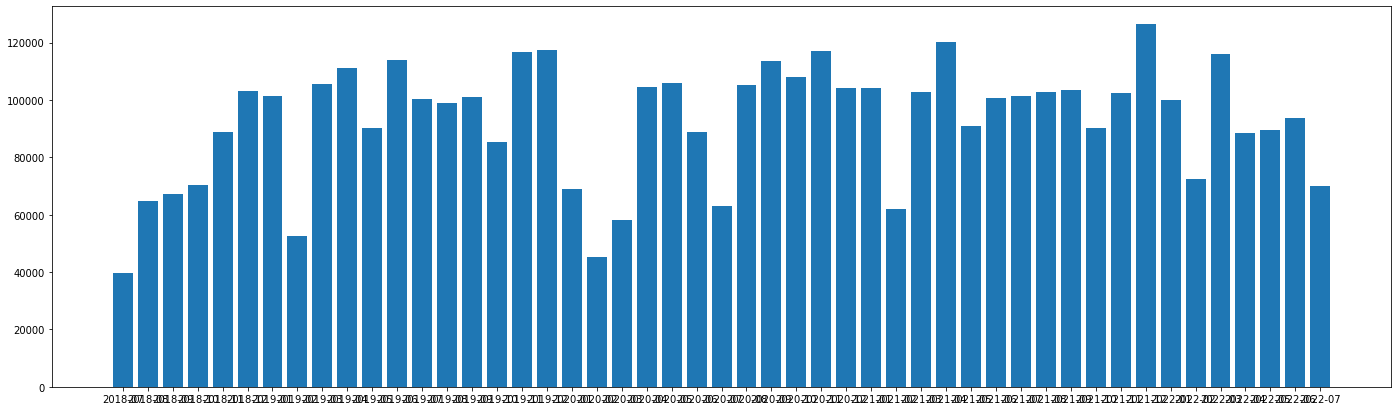

In [96]:
df_i = df.groupby('InvoiceMonthStr').agg({
    'Quantity': np.sum,
}).reset_index()
df_i.sort_values(by='InvoiceMonthStr')

plt.figure(figsize=(24, 7))
plt.bar(df_i['InvoiceMonthStr'], df_i['Quantity'])
plt.show()


## Feature selection

In [97]:
country_names = ['廣東珠三角', '台灣', '蘇州地區', '無錫地區', '常州地區', '浙北', '南通地區', '粵東地區', '福建地區', '廣西地區', ]
country_types = ['IsTrangle', 'IsTW', 'IsSu', 'IsWu', 'IsCha', 'IsChu', 'IsNan', 'IsEast', 'IsFu', 'IsWest', ]

for cname, ctype in zip(country_names, country_types):
    df[ctype] = df['Country'].apply(lambda x: 1 if x == cname else 0)
df['IsOther'] = df['Country'].apply(lambda x: 1 if x not in country_names else 0)

country_names += ['Other']
country_types += ['IsOther']


In [98]:
a = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', None)
display(df)
pd.set_option('display.max_columns', a)

,BU,OrgCOmpany,CustomerID,ScCustProf,PlanReCustIncity,Country,Prod,Grade,PackDesp,Quantity,Cur,UnitPrice,InvoiceDate,InvoiceMonth,InvoiceMonthStr,USPrice,Monetary,IsTrangle,IsTW,IsSu,IsWu,IsCha,IsChu,IsNan,IsEast,IsFu,IsWest,IsOther
0,REBU,JU,阿姆斯壯,卷材地板,江蘇吳江,蘇州地區,UN488,一般級N,散裝,89.85,RMB,8960.59,2018-07-02,2018-07,2018-07,1254.482600,8.051090e+05,0,0,1,0,0,0,0,0,0,0,0
1,REBU,JU,揚州亞明,電線電纜膠粒,江蘇揚州,揚州地區,TOTM,一般級N,散裝,2.00,RMB,12000.00,2018-07-02,2018-07,2018-07,1680.000000,2.400000e+04,0,0,0,0,0,0,0,0,0,0,1
2,REBU,JU,天長格瑞,電線電纜膠粒,安徽天長,安徽地區0,UN488,一般級N,散裝,10.00,RMB,9150.00,2018-07-02,2018-07,2018-07,1281.000000,9.150000e+04,0,0,0,0,0,0,0,0,0,0,1
3,REBU,JU,溧陽恆業,建材﹑裝飾材料,江蘇溧陽,常州地區,DOP,一般級N,散裝,20.00,RMB,8700.00,2018-07-02,2018-07,2018-07,1218.000000,1.740000e+05,0,0,0,0,1,0,0,0,0,0,0
4,REBU,JU,江蘇天邦,輸送帶,江蘇泰州,泰州地區,DOA,一般級N,190KG新桶裝,0.38,RMB,11675.20,2018-07-02,2018-07,2018-07,1634.528000,4.436576e+03,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90097,MABU,VN,HOAPHU,鞋材、鞋粒,"H. Binh Chanh,HCM",VIETNAM,DOP-T,General N,Bulk,21.00,VND,38000000.00,2022-07-13,2022-07,2022-07,1634.000000,7.980000e+08,0,0,0,0,0,0,0,0,0,0,1
90098,MABU,VN,Vitahco,直接出口,******,VIETNAM,UN488-T,General N,Bulk,21.00,VND,36883333.00,2022-07-12,2022-07,2022-07,1585.983319,7.745500e+08,0,0,0,0,0,0,0,0,0,0,1
90099,MABU,VN,HUE LINH.,建材﹑裝飾材料,******,VIETNAM,DOP-T,General N,Bulk,22.00,VND,39050000.00,2022-07-11,2022-07,2022-07,1679.150000,8.591000e+08,0,0,0,0,0,0,0,0,0,0,1
90100,MABU,VN,THPHAT,食品包裝,TRAN DAI NGHIA,VIETNAM,DOP-T,General N,Bulk,15.00,VND,38635000.00,2022-07-07,2022-07,2022-07,1661.305000,5.795250e+08,0,0,0,0,0,0,0,0,0,0,1


In [99]:
# train_months   = ['2020-07', '2022-11']
# predict_months = ['2020-08', '2022-12']

train_months = ['2020-07', '2022-06']
predict_months = ['2020-08', '2022-07']

if auto_mode:
    train_months = config['train_months']
    predict_months = config['predict_months']


In [100]:
def get_df_x(max_month, min_month):
    from datetime import datetime
    now = datetime.strptime(max_month, '%Y-%m')

    a = {t: np.mean for t in country_types}
    a['InvoiceMonth'] = np.max
    a['Quantity'] = ['mean', 'sum']
    a['USPrice'] = [lambda x: x.iloc[-1], lambda x: x.iloc[-2] if x.shape[0] > 1 else x.iloc[-1]]
    a['Monetary'] = np.sum
    a['InvoiceDate'] = [np.max, np.min]

    df_data = df.loc[(df['InvoiceMonthStr'] < max_month) & (df['InvoiceMonthStr'] >= min_month)]
    df_x = df_data.groupby('CustomerID').agg(a)
    df_x.columns = country_types + ['LastMonth', 'QuantityAvg', 'QuantityTotal', 'USPrice', 'USPriceLast', 'Monetary', 'LastPurchase', 'FirstPurchase', ]

    df_x = df_x.loc[df_x['LastPurchase'] != df_x['FirstPurchase']]

    df_x['TransCount'] = df.groupby('CustomerID').size()
    df_x['Frequency'] = df_x['TransCount'] * 30 / (df_x['LastPurchase'] - df_x['FirstPurchase']).dt.days
    df_x['Recency'] = (now - df_x['LastPurchase']).dt.days

    df_x = df_x.sort_values(by='CustomerID').reset_index()

    df_x['PriceRaise'] = (df_x['USPrice'] - df_x['USPriceLast']) / df_x['USPrice'] * 100

    # df_x = df_x.drop('LastMonth', 1)

    df_x = df_x.drop(['USPrice', 'USPriceLast', 'FirstPurchase', 'LastPurchase', 'TransCount', 'LastMonth', 'PriceRaise', ], 1)
    # df_x = df_x.drop([
    #     # 'IsTrangle',
    #     'IsTW',
    #     'IsSu',
    #     'IsWu',
    #     # 'IsCha',
    #     # 'IsChu',
    #     # 'IsNan',
    #     # 'IsOther',
    # ], 1)

    return df_x, df_data


In [101]:
def get_df_y(max_month, min_month, df_x):
    df_result = df.loc[df['InvoiceMonthStr'] == max_month].groupby('CustomerID').agg({
        'Quantity': np.sum,
    }).reset_index()

    df_q_dict = {c: i for c, i in zip(df_result['CustomerID'], df_result['Quantity'])}

    customerids = df_x['CustomerID'].unique()
    # display(len(customerids))
    customerids.sort()
    quantity = [df_q_dict[c] if c in df_q_dict else 0 for c in customerids]
    df_y = pd.DataFrame({
        'CustomerID': customerids,
        'Quantity': quantity,
    })

    return df_y


In [102]:
df_model_x, df_model_data = get_df_x(train_months[1], train_months[0])
df_model_y = get_df_y(train_months[1], train_months[0], df_model_x)

customerid = df_model_x['CustomerID'].unique()

display(df_model_x)
display(df_model_y)


,CustomerID,IsTrangle,IsTW,IsSu,IsWu,IsCha,IsChu,IsNan,IsEast,IsFu,IsWest,IsOther,QuantityAvg,QuantityTotal,Monetary,Frequency,Recency
0,3H-VN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.900000,618.00,2.576528e+10,1.796407,31
1,3M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.285714,360.00,3.982090e+06,4.857143,61
2,ALLIED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61.121212,2017.00,1.251469e+07,2.894334,31
3,AMERSEAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.600000,7.80,6.176500e+04,0.725806,211
4,AN DAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.000000,28.00,1.199100e+09,0.304569,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,龍塑佛山,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.733582,4739.15,5.307423e+07,4.461305,5
1567,龍宮河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36.000000,1728.00,1.939747e+07,4.082840,8
1568,龍崗河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38.956522,1792.00,2.078326e+07,3.333333,233
1569,龍膠河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.000000,160.00,2.131456e+06,14.193548,278


,CustomerID,Quantity
0,3H-VN,0.0
1,3M,21.0
2,ALLIED,236.0
3,AMERSEAL,0.0
4,AN DAT,0.0
...,...,...
1566,龍塑佛山,15.0
1567,龍宮河北,64.0
1568,龍崗河北,0.0
1569,龍膠河北,0.0


In [103]:
df_pred_x, df_analyze_data = get_df_x(predict_months[1], predict_months[0])
df_pred_x = df_pred_x.loc[df_pred_x['CustomerID'].isin(customerid)]
df_analyze_data = df_analyze_data.loc[df_analyze_data['CustomerID'].isin(customerid)]
df_pred_y = get_df_y(predict_months[1], predict_months[0], df_model_x)

display(df_pred_x)
display(df_pred_y)


,CustomerID,IsTrangle,IsTW,IsSu,IsWu,IsCha,IsChu,IsNan,IsEast,IsFu,IsWest,IsOther,QuantityAvg,QuantityTotal,Monetary,Frequency,Recency
0,3H-VN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.900000,618.00,2.576528e+10,1.796407,61
1,3M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.333333,372.00,4.161122e+06,4.519941,22
2,ALLIED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61.800000,2163.00,1.378529e+07,2.804154,2
3,AMERSEAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.600000,7.80,6.176500e+04,0.725806,241
4,AN DAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.000000,28.00,1.199100e+09,0.304569,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,龍塑佛山,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.913971,4754.15,5.328576e+07,4.298246,10
1575,龍宮河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.918367,1760.00,1.989034e+07,4.246154,15
1576,龍崗河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.111111,1760.00,2.054637e+07,3.525180,263
1577,龍膠河北,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.000000,160.00,2.131456e+06,14.193548,308


,CustomerID,Quantity
0,3H-VN,0.0
1,3M,0.0
2,ALLIED,0.0
3,AMERSEAL,0.0
4,AN DAT,0.0
...,...,...
1566,龍塑佛山,15.0
1567,龍宮河北,64.0
1568,龍崗河北,32.0
1569,龍膠河北,0.0


In [104]:
# raise Exception()
cus = set(df_model_x['CustomerID']) & set(df_pred_x['CustomerID'])

df_model_x = df_model_x.loc[df_model_x['CustomerID'].isin(cus)]
df_model_y = df_model_y.loc[df_model_y['CustomerID'].isin(cus)]
df_pred_x = df_pred_x.loc[df_pred_x['CustomerID'].isin(cus)]
df_pred_y = df_pred_y.loc[df_pred_y['CustomerID'].isin(cus)]

## Split Group

In [105]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [106]:
clusters = 3

kmeans = KMeans(
    init="random",
    n_clusters=clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)


In [107]:
# mon = df_model_x['Monetary'].apply(lambda x: np.log(x))
mon = df_model_x['Monetary']

features = [[x, y, z] for x, (y, z) in zip(df_model_x['Recency'], zip(df_model_x['Frequency'], mon))]

kmeans.fit(features)


KMeans(init='random', n_clusters=3, random_state=42)

In [108]:
a = set(df_model_x['CustomerID'].unique()) - set(df_pred_x['CustomerID'].unique())
a = list(a)
d = df_model_x.loc[df_model_x['CustomerID'].isin(a)]

In [109]:
label = kmeans.fit_predict(features)
df_model_x['Group'] = label
df_model_y['Group'] = label
df_pred_x['Group'] = label
df_pred_y['Group'] = label


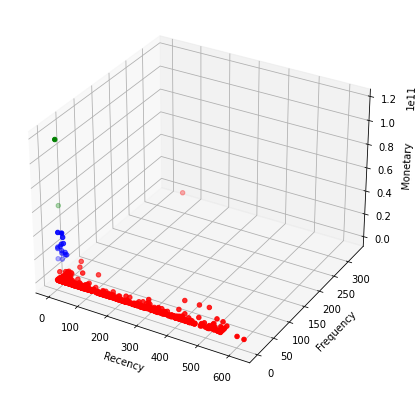

'red'

1548

'green'

2

'blue'

15

In [110]:
# %pylab qt
if not auto_mode:
    %matplotlib inline
plt.figure(figsize=(24, 7)).clear()

ax = plt.axes(projection='3d')

colors = ['red', 'green', 'blue', 'black', 'purple', ]

for i in range(clusters):
    mon = df_model_x[label == i]['Monetary']
    # mon = df_model_x[label == i]['Monetary'].apply(lambda x: np.log(x))
    ax.scatter(df_model_x[label == i]['Recency'], df_model_x[label == i]['Frequency'], mon, color=colors[i])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

for i in range(clusters):
    display(colors[i], sum(label == i))

# /imgs/country_split
# plt.savefig('C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/country_split/split.png')

if auto_mode:
    ax.figure.savefig(f'{img_path}/{config["name"]}_split.jpg')

In [111]:
# raise Exception()


## Group 1

feature

In [112]:
# display(df_model_x)
# display(df_pred_x)


In [113]:
group = [0, 1, 2, ]
c = [int(sum(label == i)) for i in range(clusters)]
group = [int(np.argmax(c))]
group_tag = 'nogroup'

if auto_mode:
    c = [int(sum(label == i)) for i in range(clusters)]
    write_config('group count', c)
    if config['dogroup']:
        group = [int(np.argmax(c))]
        group_tag = 'group'
    else:
        group = [i for i in range(clusters)]
        group_tag = 'nogroup'
    write_config('selected group', group)


In [114]:
# features = ['IsTrangle', 'IsTW', 'IsSu', 'IsWu', 'IsCha', 'IsChu', 'IsNan', 'IsOther', 'QuantityAvg', 'QuantityTotal', 'Monetary', 'Frequency', 'Recency']
# features = ['IsTrangle', 'IsCha', 'IsChu', 'IsNan', 'QuantityAvg', 'QuantityTotal', 'Monetary', 'Frequency', 'Recency']
features = ['Recency', 'Frequency', 'Monetary', 'QuantityAvg', 'QuantityTotal', 'IsTrangle', 'IsEast', 'IsFu', 'IsWest']

x = df_model_x.loc[df_model_x['Group'].isin(group)].reset_index()
x = x[features]
y = df_model_y.loc[df_model_y['Group'].isin(group)].reset_index()[['Quantity']]

x_pred = df_pred_x.loc[df_pred_x['Group'].isin(group)].reset_index()
x_pred = x_pred[features]
y_pred = df_pred_y.loc[df_pred_y['Group'].isin(group)].reset_index()[['Quantity']]


train

In [115]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=23)
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1161, 9)

(1161, 1)

(387, 9)

(387, 1)

In [116]:
if auto_mode:
    write_config('train size', X_train.shape[0])

In [117]:
linreg = XGBRegressor(
    random_state=20,
    n_jobs=-1,
)


In [118]:
model = linreg.fit(X_train, y_train)


[11:21:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


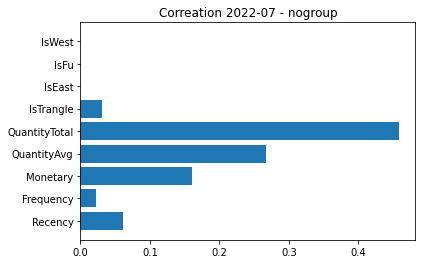

In [119]:
if not auto_mode:
    %matplotlib inline

# fig = plt.figure()
ax = plt.axes()
ax.set_title(f'Correation {predict_months[1]} - {group_tag}')
ax.barh(range(1, len(model.feature_importances_) + 1), model.feature_importances_, tick_label=X_train.columns.tolist())
plt.show()
# plt.savefig('C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/country_split/reg.png')

if auto_mode:
    ax.figure.savefig(f'{img_path}/{config["name"]}_reg_{group_tag}.jpg')


analyze

In [120]:
train_pred_y = model.predict(X_train)
test_pred_y = model.predict(X_test)


In [121]:
y_hat = model.predict(x)

df_y_hat = pd.DataFrame(y_hat)
df_y_hat.columns = ['Predict']
df_y_p = pd.DataFrame(y)


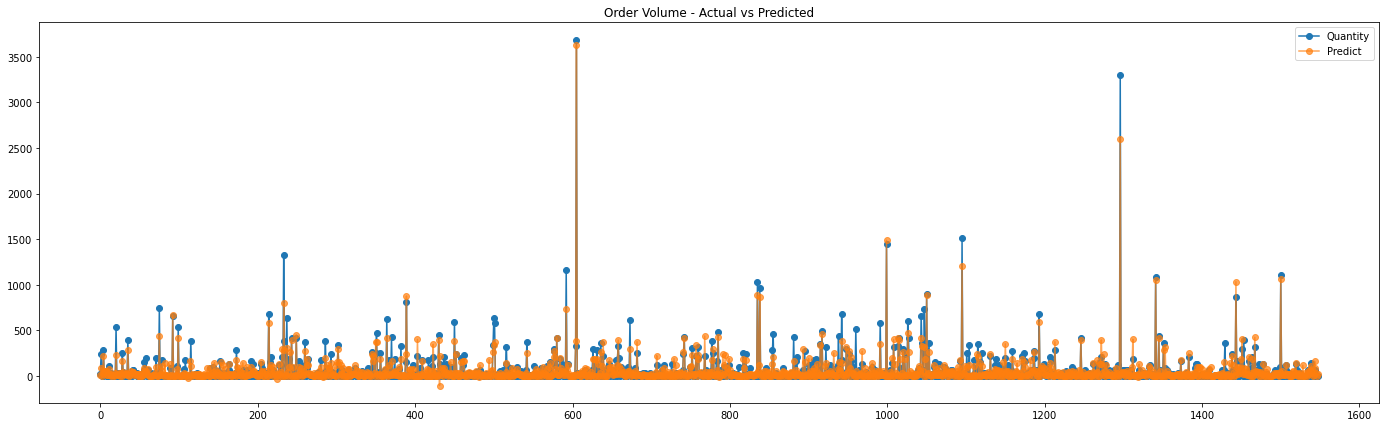

In [122]:
fig_size = (24, 7)
# fig_size = (44, 10)

# s, e = 0, 200
# s, e = 0, len(df_y_hat)

ax = df_y_p.plot(
    label="actual", figsize=fig_size, marker="o"
)
df_y_hat.plot(
    ax=ax,
    title="Order Volume - Actual vs Predicted",
    alpha=0.7,
    figsize=fig_size,
    marker="o",
)

# plt.ylim([0, 200])

plt.legend()
plt.show()

In [123]:
y_hat_pred = model.predict(x_pred)

df_y_hat_pred = pd.DataFrame(y_hat_pred)
df_y_hat_pred.columns = ['predict']
df_y_p_pred = pd.DataFrame(y_pred)


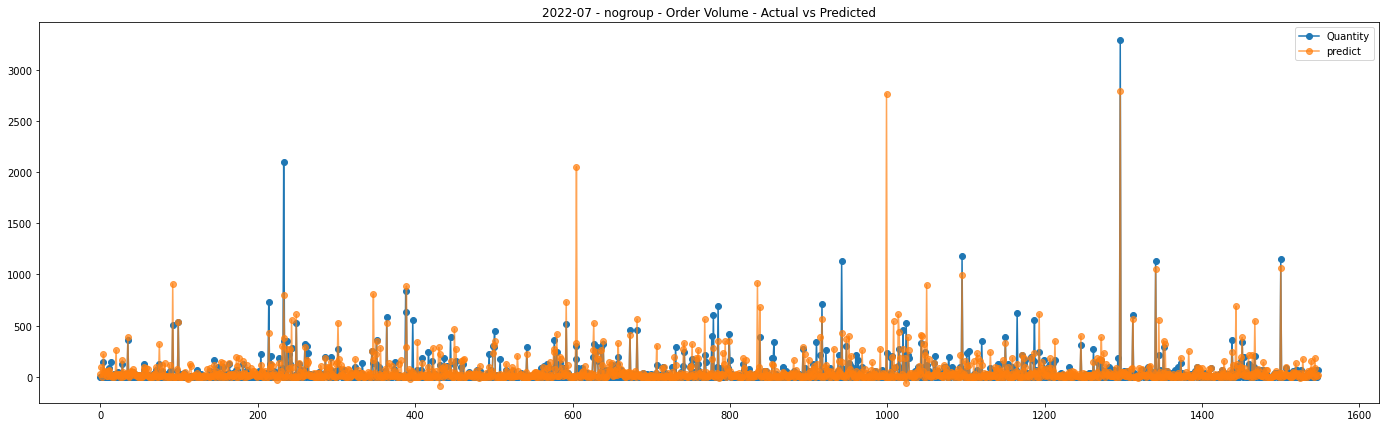

In [124]:
fig_size = (24, 7)
# fig_size = (44, 10)

# s, e = 0, 200
# s, e = 0, len(df_y_hat)

ax = df_y_p_pred.plot(
    label="actual", figsize=fig_size, marker="o"
)
df_y_hat_pred.plot(
    ax=ax,
    title=f"{predict_months[1]} - {group_tag} - Order Volume - Actual vs Predicted",
    alpha=0.7,
    figsize=fig_size,
    marker="o",
)

# plt.ylim([0, 200])

plt.legend()
plt.show()

# plt.savefig('C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/country_split/pred.png')

if auto_mode:
    ax.figure.savefig(f'{img_path}/{config["name"]}_pred_{"group" if config["dogroup"] else "nogroup"}.jpg')


In [125]:
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))
mae_train = mean_absolute_error(y_train, train_pred_y)
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))
mae_test = mean_absolute_error(y_test, test_pred_y)

display('MSE train: {:.3f}, MAE train: {:.3f}\nMSE test: {:.3f}, MAE test: {:.3f}'.format(
    mse_train,
    mae_train,
    mse_test,
    mae_test
))

'MSE train: 56.630, MAE train: 29.310\nMSE test: 76.169, MAE test: 34.381'

In [126]:
mse_pred = np.sqrt(mean_squared_error(df_y_p_pred, df_y_hat_pred))
mae_pred = mean_absolute_error(df_y_p_pred, df_y_hat_pred)

display(f'MSE pred: {round(mse_pred, 2)}, MAE pred: {round(mae_pred, 2)}')


'MSE pred: 120.8, MAE pred: 40.69'

In [127]:
if auto_mode:
    error = {
        'mse_train': int(mse_train),
        'mae_train': int(mae_train),
        'mse_test': int(mse_test),
        'mae_test': int(mae_test),
        'mse_pred': int(mse_pred),
        'mae_pred': int(mae_pred),
    }
    write_config('error', error)

In [128]:
ols_reg = sm.OLS(y_hat_pred, x_pred)
ols_reg = ols_reg.fit()
display(ols_reg.summary())

if auto_mode:
    write_config('rsquared', round(ols_reg.rsquared, 2))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                              394.4
Date:                Tue, 29 Nov 2022   Prob (F-statistic):                        0.00
Time:                        11:21:52   Log-Likelihood:                         -9226.7
No. Observations:                1548   AIC:                                  1.847e+04
Df Residuals:                    1539   BIC:                                  1.852e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Recency          -0.1287      0.015     -8.842      0.000      -0.157      -0.100
Frequency         0.4786      0.252      1.902      0.057      -0.015       0.972
Monetary       3.693e-10   4.18e-09      0.088      0.930   -7.83e-09    8.57e-09
QuantityAvg       1.1699      0.076     15.494      0.000       1.022       1.318
QuantityTotal     0.0247      0.001     31.200      0.000       0.023       0.026
IsTrangle       -11.5155      5.841     -1.971      0.049     -22.974      -0.057
IsEast          -26.0190     20.308     -1.281      0.200     -65.853      13.815
IsFu            -27.9479     26.023     -1.074      0.283     -78.992      23.096
IsWest           -5.1155     35.652     -0.143      0.886     -75.048      64.817
==============================================================================
Omnibus:                     2168.214   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2070368.268
Skew:                           7.334   Prob(JB):                         0.00
Kurtosis:                     181.560   Cond. No.                     8.57e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.57e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Analyze Quantity & Transaction distribution

In [129]:
total_quantity = df.groupby('InvoiceMonth').agg({
    "Quantity": ['sum']
}).reset_index()
total_quantity.columns = ['InvoiceMonth', 'Quantity', ]

count = df.groupby(['InvoiceMonth']).agg({
    "Quantity": ['count']
}).reset_index()
count.columns = ['InvoiceMonth', 'Count', ]


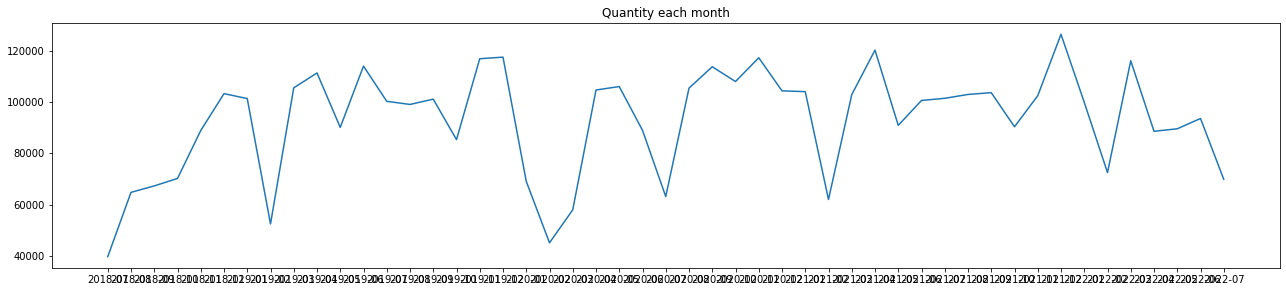

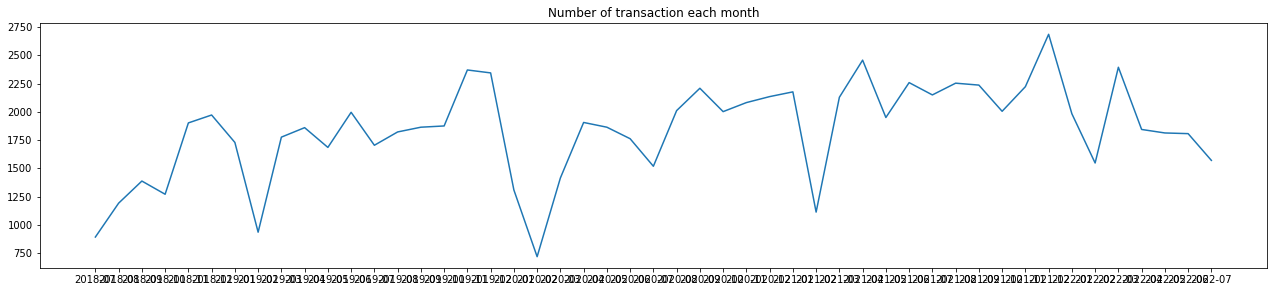

In [130]:
plt.figure(figsize=(22, 4.5))
plt.title('Quantity each month')
plt.plot(total_quantity['Quantity'])
plt.xticks(range(0, len(total_quantity)), total_quantity['InvoiceMonth'])
plt.show()

plt.figure(figsize=(22, 4.5))
plt.title('Number of transaction each month')
plt.plot(count['Count'])
plt.xticks(range(0, len(count)), count['InvoiceMonth'])
plt.show()


## Train with whole year

In [131]:
from dateutil.relativedelta import relativedelta

date_format = '%Y-%m'

def month_dif(d1: datetime, d2: datetime):
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def add_month(d1: datetime, month: int):
    if month == 0:
        return d1
    is_pos = month > 0
    month = abs(month)
    year = month // 12

    if year == 0:
        return d1 + relativedelta(months=month % 12) * (1 if is_pos else -1)
    else:
        return d1 + relativedelta(years=year, months=month % 12) * (1 if is_pos else -1)

def generate_months(start_month, end_month, last_month):
    months = []
    for i in range(month_dif(last_month, end_month) + 1):
        a = [
            add_month(start_month, i),
            add_month(end_month, i - 1),
            add_month(start_month, i+1),
            add_month(end_month, i),
        ]
        a = [m.strftime(date_format) for m in a]
        # print(f'{a[0]}~{a[1]} -> {a[2]}~{a[3]}')
        months.append(a)
    return months

Set time

In [132]:
train_start = datetime.strptime('2020-07', date_format)
train_end   = datetime.strptime('2021-08', date_format)
train_last  = datetime.strptime('2022-05', date_format)

pred_start  = datetime.strptime('2021-05', date_format)
pred_end    = datetime.strptime('2022-06', date_format)
pred_last   = datetime.strptime('2022-08', date_format)

path = '../imgs/all_country'
img_path = f'{path}/all_filter'
# img_path = f'{path}/all'
# img_path = f'{path}/RSBU'
# img_path = f'{path}/REBU'
# img_path += '_asdasdasd' # disable save image
# do_group = False
do_group = True

if auto_mode:
    train_start = datetime.strptime(config['train_months'][0], date_format)
    train_end   = datetime.strptime(config['train_months'][1], date_format)
    train_last  = datetime.strptime(config['train_months'][2], date_format)

    pred_start  = datetime.strptime(config['predict_months'][0], date_format)
    pred_end    = datetime.strptime(config['predict_months'][1], date_format)
    pred_last   = datetime.strptime(config['predict_months'][2], date_format)

    img_path = f'{path}/{config["name"]}'
    do_group = config['dogroup']
    

Train data selection

In [133]:
def select_group(df_model_x, df_model_y):
    kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )

    features = [[x, y, z] for x, (y, z) in zip(df_model_x['Recency'], zip(df_model_x['Frequency'], df_model_x['Monetary']))]

    kmeans.fit(features)
    label = kmeans.fit_predict(features)

    unique, counts = np.unique(label, return_counts=True)
    max_index = np.argmax(counts)

    df_model_x['group'] = label
    df_model_x = df_model_x.loc[df_model_x['group'] == max_index].drop(['group'], 1)

    df_model_y['group'] = label
    df_model_y = df_model_y.loc[df_model_y['group'] == max_index].drop(['group'], 1)

    return df_model_x, df_model_y


In [134]:
train_months = generate_months(train_start, train_end, train_last)
train_data = []

for m in train_months:
    df_model_x, df_model_data = get_df_x(m[1], m[0])
    df_model_y = get_df_y(m[1], m[0], df_model_x)

    if do_group:
        df_model_x, df_model_y = select_group(df_model_x, df_model_y)
    
    train_data.append([m[1], df_model_x, df_model_y])

In [135]:
features_x = ['Recency', 'Frequency', 'Monetary', 'QuantityAvg', 'QuantityTotal', 'IsTrangle', 'IsEast', 'IsFu', 'IsWest']
features_y = ['Quantity', ]

df_train_x = pd.DataFrame(columns=features_x)
df_train_y = pd.DataFrame(columns=features_y)
test_data = []

for pred_month, df_model_x, df_model_y in train_data:
    X_train, X_test, y_train, y_test = train_test_split(df_model_x[features_x], df_model_y[features_y], test_size=0.25, random_state=23)
    df_train_x = df_train_x.append(X_train, ignore_index=True)
    df_train_y = df_train_y.append(y_train, ignore_index=True)
    test_data.append([pred_month, X_train, X_test, y_train, y_test, ])
df_train_x['Recency'] = df_train_x['Recency'].astype(np.int64)

Predict data selection

In [136]:
pred_months = generate_months(pred_start, pred_end, pred_last)
pred_data = []

for m in pred_months:
    df_pred_x, df_pred_data = get_df_x(m[1], m[0])
    df_pred_y = get_df_y(m[1], m[0], df_pred_x)

    if do_group:
        df_pred_x, df_pred_y = select_group(df_pred_x, df_pred_y)

    df_pred_x, df_pred_y = df_pred_x[features_x], df_pred_y[features_y]

    pred_data.append([m[1], df_pred_x, df_pred_y])

train

In [137]:
model = XGBRegressor(
    random_state=20,
    n_jobs=-1,
)


In [138]:
model = model.fit(df_train_x, df_train_y)


[11:22:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


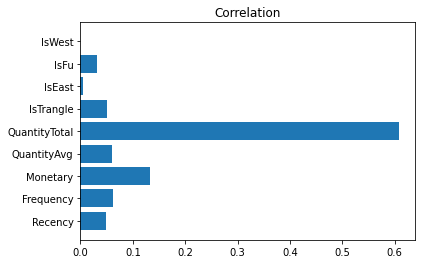

In [139]:
if not auto_mode:
    %matplotlib inline

# fig = plt.figure()
ax = plt.axes()
title = 'Correlation'
ax.set_title(title)
ax.barh(range(1, len(model.feature_importances_) + 1), model.feature_importances_, tick_label=X_train.columns.tolist())
plt.show()
# plt.savefig('C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/country_split/reg.png')

# if auto_mode:
# ax.figure.savefig(f'{img_path}/{title}.jpg')


predict

In [140]:
train_months = []
test = []
test_real = []
mse_test = []
mae_test = []
rsquare_test = []
mse_train = []
mae_train = []
rsquare_train = []

for pred_month, X_train, X_test, y_train, y_test in test_data:
    train_months.append(pred_month)

    test.append(pd.DataFrame(model.predict(X_test)))
    test_real.append(y_test)
    mse_test.append(np.sqrt(mean_squared_error(test[-1], test_real[-1])))
    mae_test.append(mean_absolute_error(test[-1], test_real[-1]))

    ols_reg = sm.OLS(test[-1], X_test.reset_index())
    ols_reg = ols_reg.fit()
    rsquare_test.append(ols_reg.rsquared)

    train_pred = pd.DataFrame(model.predict(X_train))
    mse_train.append(np.sqrt(mean_squared_error(train_pred, y_train)))
    mae_train.append(mean_absolute_error(train_pred, y_train))

    ols_reg = sm.OLS(train_pred, X_train.reset_index())
    ols_reg = ols_reg.fit()
    rsquare_train.append(ols_reg.rsquared)


In [141]:
pred_months = []
pred = []
pred_real = []
mse_pred = []
mae_pred = []
rsquare_pred = []

for pred_month, df_model_x, df_model_y in pred_data:
    pred_months.append(pred_month)

    pred.append(pd.DataFrame(model.predict(df_model_x)))

    pred_real.append(df_model_y)

    mse_pred.append(np.sqrt(mean_squared_error(pred[-1], pred_real[-1])))
    mae_pred.append(mean_absolute_error(pred[-1], pred_real[-1]))

    ols_reg = sm.OLS(pred[-1], df_model_x.reset_index())
    ols_reg = ols_reg.fit()
    rsquare_pred.append(ols_reg.rsquared)

    p = pred[-1].sort_values(by=0).reset_index()[[0]]
    p = p.iloc[::4, :]
    pred[-1] = p

    p = pred_real[-1].sort_values(by='Quantity').reset_index()[['Quantity']]
    p = p.iloc[::4, :]
    pred_real[-1] = p


In [142]:
print(train_months)
print(pred_months)

['2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04']
['2022-05', '2022-06', '2022-07']


plot

In [143]:
test_list = [p[0].tolist() for p in test]
test_real_list = [p['Quantity'].tolist() for p in test_real]

pred_list = [p[0].tolist() for p in pred]
pred_real_list = [p['Quantity'].tolist() for p in pred_real]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


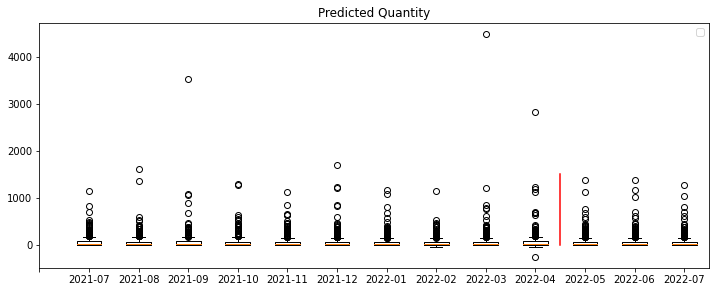

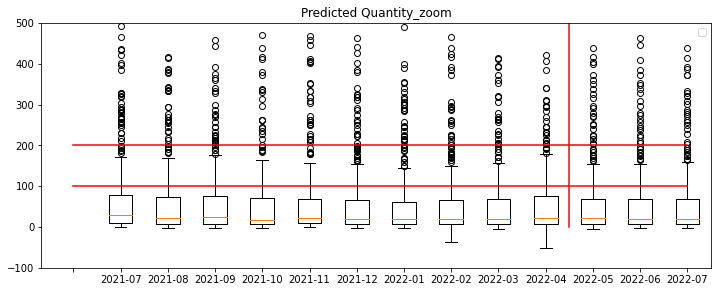

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


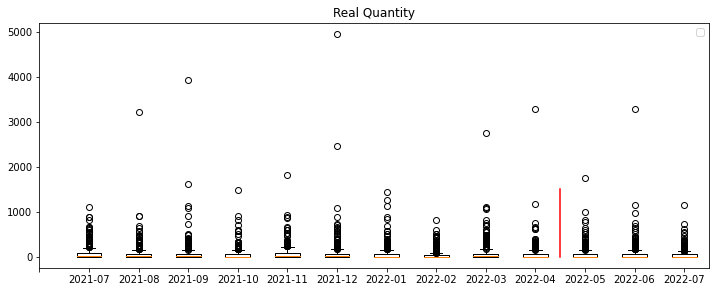

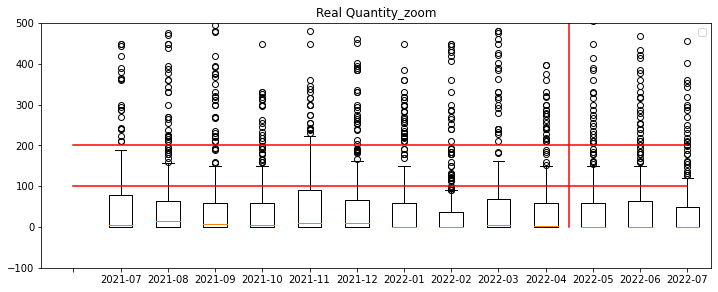

In [144]:

months = train_months + pred_months

fig = plt.figure(figsize=(12, 4.5))
title = 'Predicted Quantity'
fig.canvas.manager.set_window_title(title)
ax = plt.axes()
ax.set_title(title)
ax.boxplot(test_list + pred_list)
# ax = seaborn.stripplot(data=[[]] + test_list + pred_list)
ax.plot([10.5, 10.5], [0, 1500], 'r')
ax.legend()
ax.set_xticks(range(0, len(months) + 1), [''] + months)
plt.show()
# ax.figure.savefig(f'{img_path}/{title}.jpg')

plt.sca(ax)
title += '_zoom'
ax.set_title(title)
ax.set_ylim(bottom=-100, top=500)
ax.plot([0, len(months)], [200, 200], 'r')
ax.plot([0, len(months)], [100, 100], 'r')
plt.show()
# ax.figure.savefig(f'{img_path}/{title}.jpg')

fig = plt.figure(figsize=(12, 4.5))
title = 'Real Quantity'
fig.canvas.manager.set_window_title(title)
ax = plt.axes()
ax.set_title(title)
ax.boxplot(test_real_list + pred_real_list)
ax.plot([10.5, 10.5], [0, 1500], 'r')
ax.legend()
ax.set_xticks(range(0, len(months) + 1), [''] + months)
plt.show()
# ax.figure.savefig(f'{img_path}/{title}.jpg')

plt.sca(ax)
title += '_zoom'
ax.set_title(title)
ax.set_ylim(bottom=-100, top=500)
ax.plot([0, len(months)], [200, 200], 'r')
ax.plot([0, len(months)], [100, 100], 'r')
plt.show()
# ax.figure.savefig(f'{img_path}/{title}.jpg')


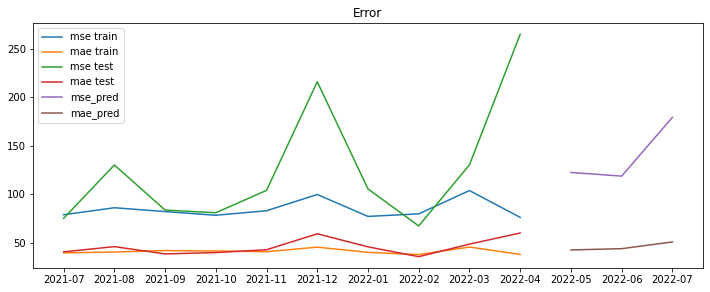

In [145]:
fig = plt.figure(figsize=(12, 4.5))
fig.canvas.manager.set_window_title('Error')
title = 'Error'
ax = plt.axes()
ax.set_title(title)
ax.plot(mse_train, label="mse train")
ax.plot(mae_train, label="mae train")
ax.plot(mse_test, label="mse test")
ax.plot(mae_test, label="mae test")
ax.plot([len(mse_train) + i for i in range(len(mse_pred))], mse_pred, label="mse_pred")
ax.plot([len(mse_train) + i for i in range(len(mse_pred))], mae_pred, label="mae_pred")
ax.legend()
ax.set_xticks(range(0, len(train_months) + len(pred_months)), train_months + pred_months)
plt.show()
# ax.figure.savefig(f'{img_path}/{title}.jpg')


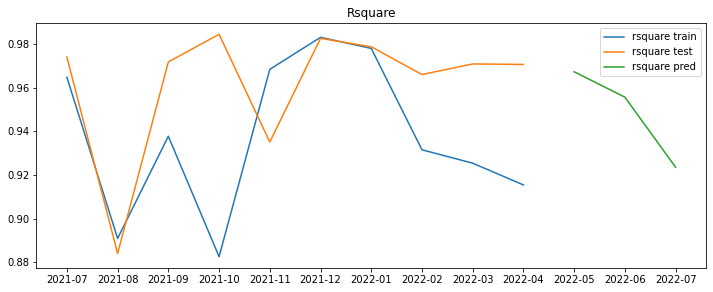

In [146]:
fig = plt.figure(figsize=(12, 4.5))
fig.canvas.manager.set_window_title('Rsquare')
ax = plt.axes()
title = 'Rsquare'
ax.set_title(title)
ax.plot(rsquare_train, label="rsquare train")
ax.plot(rsquare_test, label="rsquare test")
ax.plot([len(mse_train) + i for i in range(len(rsquare_pred))], rsquare_pred, label="rsquare pred")
ax.legend()
ax.set_xticks(range(0, len(train_months) + len(pred_months)), train_months + pred_months)
plt.show()

# ax.figure.savefig(f'{img_path}/{title}.jpg')


## Frequency analyze

In [147]:
customers = df['CustomerID'].unique()
train_months

df_freq = pd.DataFrame(columns=['CustomerID', 'Frequency', 'Month', 'BU'])

for td in train_data:
    month = td[0]
    
    # df_m = td[1]
    df_m, _ = select_group(td[1], td[2])

    d = df_m[['CustomerID', 'Frequency']]
    d['Month'] = month
    d['BU'] = 'allgroup'
    df_freq = pd.concat([df_freq, d], axis=0)

# df_freq.to_csv('C:/Users/eric/Desktop/ML_test/keras/predict_transaction/imgs/all_country/freq/allgroup.csv')